In [1]:
import tensorflow as tf
import random
import glob
import numpy as np
import os.path as path
import cv2
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(123)

In [3]:
def load_img (img_path):
    image_path=img_path
    file_path=glob.glob(path.join(image_path, '*.png'))

    #파일 이름에 맞는 이미지 불러오기
    images=[cv2.imread(path, cv2.IMREAD_ANYCOLOR) for path in file_path]
    images=np.asarray(images, dtype=np.float32)

    # 이미지 값이 0~1이 되도록 이미지 크기를 변경
    images=images/255
    
    # 이미지이름중 맨 앞 글자를 가져와서 라벨을 만든다
    n_images=images.shape[0]
    labels=[]
    for i in range(n_images):
        filenames=path.basename(file_path[i])[0]
        filenames=int(filenames)
        if filenames == 0:
            filename=[1.,0.]
        else:
            filename=[0.,1.]
        labels.append(filename)
    labels=np.asarray(labels)
    return(images, labels)

In [4]:
d_images, d_labels = load_img('uijoong_face')
none_images, none_labels = load_img('another_face')

In [7]:
# train 데이터 만들기
def seperate_train_test (images, labels, rate):
    train_test_split = rate
    n_images = images.shape[0]
    split_index = int(train_test_split*n_images)
    shuffled_indices=np.random.permutation(n_images) #array 셔플
    train_indices=shuffled_indices[0:split_index]
    test_indices=shuffled_indices[split_index:]

    x_train = images[train_indices,:,:]
    y_train = labels[train_indices]
    x_test = images[test_indices,:,:]
    y_test = labels[test_indices]
    
    return(x_train, y_train, x_test, y_test)

In [8]:
d_x_train, d_y_train, d_x_test, d_y_test = seperate_train_test(d_images, d_labels, 0.7)
none_x_train, none_y_train, none_x_test, none_y_test = seperate_train_test(none_images, none_labels, 0.7)

In [10]:
x_train = np.r_[d_x_train, none_x_train]
y_train = np.r_[d_y_train, none_y_train]
x_test = np.r_[d_x_test, none_x_test]
y_test = np.r_[d_y_test, none_y_test]

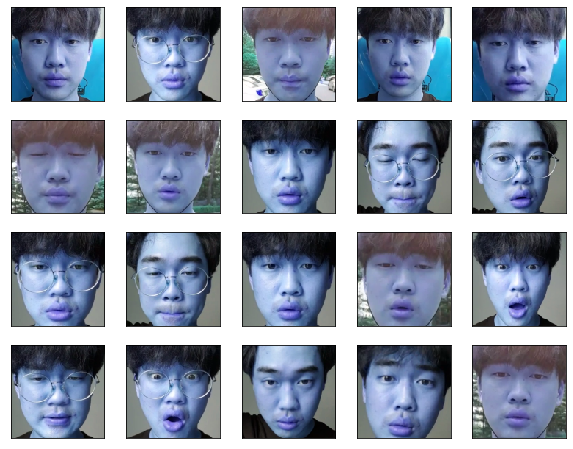

In [12]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
 hist = model.fit(x_train, y_train, batch_size=128, 
                  epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 553 samples, validate on 237 samples
Epoch 1/10
553/553 [==============================] - 11s 20ms/sample - loss: 1.7363 - accuracy: 0.6329 - val_loss: 0.6775 - val_accuracy: 0.6962
Epoch 2/10
553/553 [==============================] - 10s 18ms/sample - loss: 0.6229 - accuracy: 0.6962 - val_loss: 0.5478 - val_accuracy: 0.6962
Epoch 3/10
553/553 [==============================] - 10s 17ms/sample - loss: 0.5114 - accuracy: 0.6962 - val_loss: 0.4987 - val_accuracy: 0.6962
Epoch 4/10
553/553 [==============================] - 10s 17ms/sample - loss: 0.4680 - accuracy: 0.6962 - val_loss: 0.3758 - val_accuracy: 0.6962
Epoch 5/10
553/553 [==============================] - 9s 17ms/sample - loss: 0.3585 - accuracy: 0.6962 - val_loss: 0.3050 - val_accuracy: 0.7553
Epoch 6/10
553/553 [==============================] - 9s 17ms/sample - loss: 0.2952 - accuracy: 0.8300 - val_loss: 0.2510 - val_accuracy: 0.9198
Epoch 7/10
553/553 [==============================] - 9s 17ms/sample - loss: 0.2

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

In [24]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20924093211777037
Test accuracy: 0.98734176


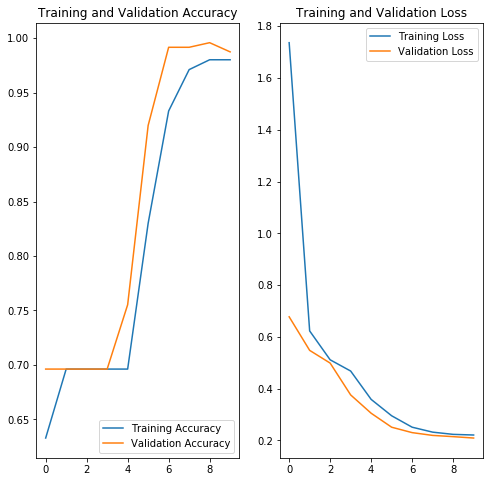

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 모자이크 처리

In [26]:
image1 = cv2.imread('0 (250).png')

In [27]:
detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [28]:
gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

In [29]:
faces = detector.detectMultiScale(gray, 1.3, 5)
for (x, y, w, h) in faces:
    roi = image1[y:y+h, x:x+w]
    dst = cv2.resize(roi, dsize=(128, 128), interpolation=cv2.INTER_AREA)
    dst_1 = dst.reshape(1, 49152)

In [34]:
mosaic_rate = 30

face_img = cv2.resize(roi, (w//mosaic_rate, h//mosaic_rate))
# 확대/축소한 그림을 원래 크기로 돌리기
face_img = cv2.resize(face_img, (w, h), interpolation=cv2.INTER_AREA)
# 원래 이미지에 붙이기
image1[y:y+h, x:x+w] = face_img

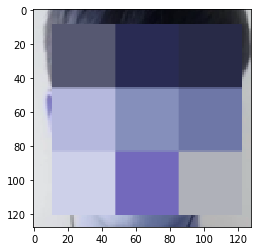

In [38]:
plt.imshow(image1)

## 웹카메라

In [75]:
import numpy as np
import cv2

mosaic_rate = 30
detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

videofile1 = 'final_test.mp4'
video = cv2.VideoCapture(videofile1)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('face_mosaic.avi', fourcc, 30.0, (640, 480))

i=0
ok=0
no=0
while (True):
    ret, img = video.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi=img[y:y+h, x:x+w]
        dst=cv2.resize(roi, dsize=(128,128),interpolation=cv2.INTER_AREA)
        dst_1=np.expand_dims(dst,0)
        dst_2 = tf.image.convert_image_dtype(dst_2, tf.float32)
        
        predict = model.predict(dst_2)
        
        if tf.argmax(predict,1) == 0 :
            no=no+1
            #print('no:',no)

            face_img = cv2.resize(roi, (w//mosaic_rate, h//mosaic_rate))
        # 확대/축소한 그림을 원래 크기로 돌리기
            face_img = cv2.resize(face_img, (w, h), interpolation=cv2.INTER_AREA)
        # 원래 이미지에 붙이기
            img[y:y+h, x:x+w] = face_img
        
        else :
            ok=ok+1
            #print('ok:', ok)
        

    cv2.imshow('frame', img)
    writer.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

        
video.release()
writer.release()
cv2.destroyAllWindows()

no: 1
no: 2
no: 3
no: 4
no: 5
no: 6
no: 7
no: 8
no: 9
no: 10
no: 11
no: 12
no: 13
no: 14
no: 15
no: 16
no: 17
no: 18
no: 19
no: 20
no: 21
no: 22
no: 23
no: 24
no: 25
no: 26
no: 27
no: 28
no: 29
no: 30
no: 31
no: 32
no: 33
no: 34
no: 35
no: 36
no: 37
no: 38
no: 39
no: 40
no: 41
no: 42
no: 43
no: 44
no: 45
no: 46
no: 47
no: 48
no: 49
no: 50
no: 51
no: 52
no: 53
no: 54
no: 55
no: 56
no: 57
no: 58
no: 59
no: 60
no: 61
no: 62
no: 63
no: 64
no: 65
no: 66
no: 67
no: 68
no: 69
no: 70
no: 71
no: 72
no: 73
no: 74
no: 75
no: 76
no: 77
no: 78
no: 79
no: 80
no: 81
no: 82
no: 83
no: 84
no: 85
no: 86
no: 87
no: 88
no: 89
no: 90
no: 91
no: 92
no: 93
no: 94
no: 95
no: 96
no: 97
no: 98
no: 99
no: 100
no: 101
no: 102
no: 103
no: 104
no: 105
no: 106
no: 107
no: 108
no: 109
no: 110
no: 111
no: 112
no: 113
no: 114
no: 115
no: 116
no: 117
no: 118
no: 119
no: 120
no: 121
no: 122
no: 123
no: 124
no: 125
no: 126
no: 127
no: 128
no: 129
no: 130
no: 131
no: 132
no: 133
no: 134
no: 135
no: 136
no: 137
no: 138
no: 

error: OpenCV(4.1.2) C:\projects\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [76]:
import numpy as np
import cv2

mosaic_rate = 30
detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


video = cv2.VideoCapture(0)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
writer = cv2.VideoWriter('face_mosaic.avi', fourcc, 10.0, (640, 480))

i=0
ok=0
no=0
while (True):
    ret, img = video.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi=img[y:y+h, x:x+w]
        dst=cv2.resize(roi, dsize=(128,128),interpolation=cv2.INTER_AREA)
        dst=cv2.resize(roi, dsize=(128,128),interpolation=cv2.INTER_AREA)
        dst_1=np.expand_dims(dst,0)
        dst_2 = tf.image.convert_image_dtype(dst_2, tf.float32)
        
        predict = model.predict(dst_2)
        
        if tf.argmax(predict,1) == 0 :
            no=no+1
            print('no:',no)

            face_img = cv2.resize(roi, (w//mosaic_rate, h//mosaic_rate))
        # 확대/축소한 그림을 원래 크기로 돌리기
            face_img = cv2.resize(face_img, (w, h), interpolation=cv2.INTER_AREA)
        # 원래 이미지에 붙이기
            img[y:y+h, x:x+w] = face_img
        
        else :
            ok=ok+1
            print('ok:', ok)
        

    cv2.imshow('frame', img)
    writer.write(img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

        
video.release()
writer.release()
cv2.destroyAllWindows()

no: 1
no: 2
no: 3
no: 4
no: 5
no: 6
no: 7
no: 8
no: 9
no: 10
no: 11
no: 12
no: 13
no: 14
no: 15
no: 16
no: 17
no: 18
no: 19
no: 20
no: 21
no: 22
no: 23
no: 24
no: 25
no: 26
no: 27
no: 28
no: 29
no: 30
no: 31
no: 32
no: 33
no: 34
no: 35
no: 36
no: 37
no: 38
no: 39
no: 40
no: 41
no: 42
no: 43
no: 44
no: 45
no: 46
no: 47
no: 48
no: 49
no: 50
no: 51
no: 52
no: 53
no: 54
no: 55
no: 56
no: 57
no: 58
no: 59
no: 60
no: 61
no: 62
no: 63
no: 64
no: 65
no: 66
no: 67
no: 68
no: 69
no: 70
no: 71
no: 72
no: 73
no: 74
no: 75
no: 76
no: 77
no: 78
no: 79
no: 80
no: 81
no: 82
no: 83
no: 84
no: 85
no: 86
no: 87
no: 88
no: 89
no: 90
no: 91
no: 92
no: 93
no: 94
no: 95
no: 96
no: 97
no: 98
no: 99
no: 100
no: 101
no: 102
no: 103
no: 104
no: 105
no: 106
no: 107
no: 108
no: 109
no: 110
no: 111
no: 112
no: 113
no: 114
no: 115
no: 116
no: 117
no: 118
no: 119
no: 120
no: 121
no: 122
no: 123
no: 124
no: 125
no: 126
no: 127
no: 128
no: 129
no: 130
no: 131
no: 132
no: 133
no: 134
no: 135
no: 136
no: 137
no: 138
no: 

KeyboardInterrupt: 